In [1]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, LeakyReLU, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import numpy as np
import cv2
import os

In [2]:
# for simplicity only taking from the train folder
dir = 'cell_images/train/'
size = 64
images = []
labels = []
input_size = 10000

In [3]:
for folder_name in ['parasitized/', 'uninfected/']:

    images_path = os.listdir(dir + folder_name)

    counter = 0
    for i, image_name in enumerate(images_path):
        try:
            image = Image.open(dir + folder_name + image_name)
            image = image.resize((size, size))
            images.append(np.array(image))

            if folder_name=='parasitized/':
                labels.append(1)
            else:
                labels.append(0)

            counter += 1
            if (counter == input_size):
                break   
        except Exception:
            pass       

images = np.array(images)
labels = np.array(labels)

In [4]:
print("Shape of the image arrays:", images.shape)
print(type(images))

Shape of the image arrays: (20000, 64, 64, 3)
<class 'numpy.ndarray'>


In [5]:
def segment(img):
    twoDimage = img.reshape((-1,3))
    twoDimage = np.float32(twoDimage)
    max_itr=30
    eps= 0.5
    K = 3
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,max_itr , eps)
    attempts=20
    ret,label,center=cv2.kmeans(twoDimage,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
    center = np.uint8(center)
    res = center[label.flatten()]
    result_image = res.reshape((img.shape))

    return result_image

In [6]:
def morph(img):
    gradient = cv2.morphologyEx(img, cv2.MORPH_GRADIENT, np.ones((5,5),np.uint8))
    return gradient

Before transformation - infected: 


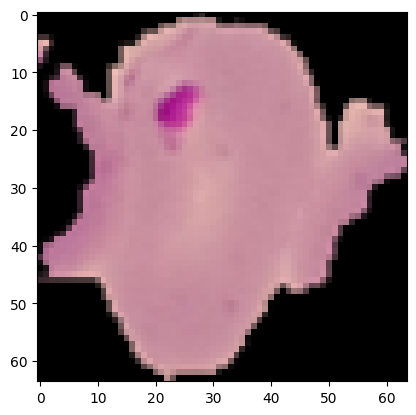

In [7]:
print("Before transformation - infected: ")
plt.imshow(images[np.random.randint(0, input_size)])

Before transformation - uninfected: 


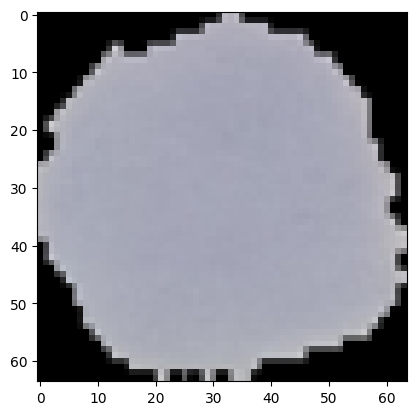

In [8]:
print("Before transformation - uninfected: ")
plt.imshow(images[np.random.randint(input_size, input_size*2)])

In [9]:
# images_transformed = [segment(img) for img in images]
images_transformed = [morph(img) for img in images]
images_transformed = np.array(images_transformed)

After transformation - infected: 


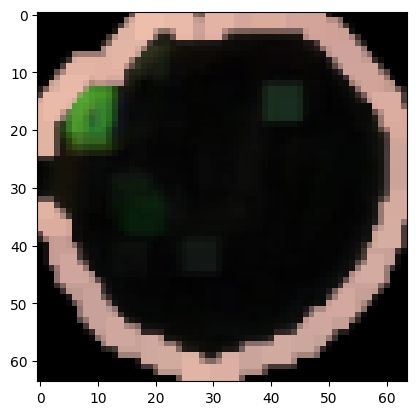

In [10]:
print("After transformation - infected: ")
plt.imshow(images_transformed[np.random.randint(0, input_size)])

After transformation - uninfected: 


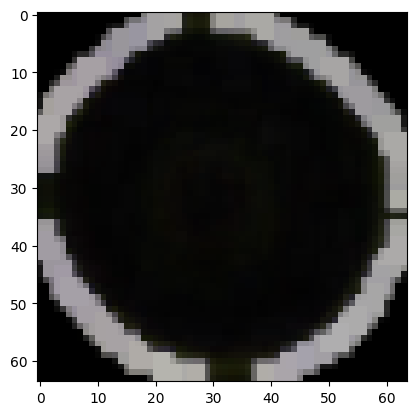

In [11]:
print("After transformation - uninfected: ")
plt.imshow(images_transformed[np.random.randint(input_size, input_size*2)])

In [12]:
images_transformed = images_transformed / 255.0
X_train_full, X_test, y_train_full, y_test = train_test_split(images_transformed, labels, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)
X_train_full[0].shape

(64, 64, 3)

In [13]:
model = tf.keras.Sequential()
model.add(Conv2D(16, 3, padding='same',input_shape=(size, size, 3)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(32, 3, padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(32, activation='relu')) 
model.add(LeakyReLU())
model.add(Dense(16, activation='relu'))
model.add(LeakyReLU())
model.add(Dense(1, activation='sigmoid'))

adam = optimizers.Adam(learning_rate=0.001)

c:\Users\Obaid\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Obaid\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [14]:
model.compile(loss="binary_crossentropy", optimizer=adam, metrics=["accuracy", tf.keras.metrics.Recall()])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       262,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 267,809 (1.02 MB)

 Trainable params: 267,809 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
class CustomEarlyStopping(Callback):
    def __init__(self, monitor1='val_loss', monitor2='val_recall', patience=3, mode1='min', mode2='max'):
        super(CustomEarlyStopping, self).__init__()
        self.monitor1 = monitor1  # First metric to monitor (e.g., val_loss)
        self.monitor2 = monitor2  # Second metric to monitor (e.g., val_recall)
        self.patience = patience  # Number of epochs to wait before stopping
        self.mode1 = mode1        # 'min' means lower is better (for loss), 'max' means higher is better (for recall)
        self.mode2 = mode2        # Same as above, but for the second metric
        self.wait = 0             # Counter to track epochs without improvement
        self.best1 = None         # Best value of monitor1
        self.best2 = None         # Best value of monitor2
        self.stopped_epoch = 0
        self.best_weights = None # To store the best model weights

    def on_train_begin(self, logs=None):
        # Initialize best values based on mode
        self.best1 = float('inf') if self.mode1 == 'min' else float('-inf')
        self.best2 = float('inf') if self.mode2 == 'min' else float('-inf')

    def on_epoch_end(self, epoch, logs=None):
        current1 = logs.get(self.monitor1)
        current2 = logs.get(self.monitor2)

        # Check if both monitored metrics are improving
        if current1 is not None and current2 is not None:
            improvement1 = (current1 < self.best1) if self.mode1 == 'min' else (current1 > self.best1)
            improvement2 = (current2 < self.best2) if self.mode2 == 'min' else (current2 > self.best2)

            if improvement1 and improvement2:
                self.best1 = current1
                self.best2 = current2
                self.best_weights = self.model.get_weights()  # Save the current best weights
                self.wait = 0  # Reset patience counter
            else:
                self.wait += 1

            # Stop training if patience limit is reached
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print(f"Early stopping triggered at epoch {self.stopped_epoch + 1}")
            # Restore the best weights after training ends
            if self.best_weights is not None:
                self.model.set_weights(self.best_weights)

In [ ]:
# Instantiate the custom callback
custom_early_stopping = CustomEarlyStopping(monitor1='val_loss', monitor2='val_recall', patience=3, mode1='min', mode2='max')

history = model.fit(X_train, y_train, steps_per_epoch=100, epochs=50, callbacks=[custom_early_stopping], validation_data=(X_valid, y_valid))

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.6731 - loss: 0.5729 - recall: 0.7015 - val_accuracy: 0.9131 - val_loss: 0.2268 - val_recall: 0.8642
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9327 - loss: 0.1871 - recall: 0.9054 - val_accuracy: 0.9356 - val_loss: 0.1846 - val_recall: 0.9038
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9453 - loss: 0.1557 - recall: 0.9226 - val_accuracy: 0.9384 - val_loss: 0.1684 - val_recall: 0.9000
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9515 - loss: 0.1383 - recall: 0.9341 - val_accuracy: 0.9447 - val_loss: 0.1588 - val_recall: 0.9170
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9563 - loss: 0.1219 - recall: 0.9430 - val_accuracy: 0.9409 - val_loss: 0.1653 - val_recall: 0.9038
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9604 - loss: 0.1128 - recall: 0.9470 - val_accuracy: 0.9494 - val_loss: 0.1468 - val_recall: 0.941

In [17]:
y_pred = model.predict(X_test)
accuracy = model.evaluate(X_test, y_test)

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9441 - loss: 0.1766 - recall: 0.9430
